# Numerical Demonstration of Line Integrals

## Purpose

This notebook demonstrates line integrals computed directly from parametric curves and vector fields, without invoking symbolic calculus or closed-form solutions.

The goal is to make explicit that a line integral is:

- a **functional** acting on a curve and a field,
- implemented numerically via sampling and quadrature,
- independent of coordinate choice,
- sensitive to **path dependence** unless special structure (e.g. conservative fields) exists.

## Mathematical Definitions

Let a curve $C$ be parameterized by
$$
\mathbf{r}(t) = (x(t), y(t)), \quad t \in [t_0, t_1],
$$
with tangent vector
$$
d\mathbf{r} = \mathbf{r}'(t)\,dt.
$$

### Vector Line Integral (Work / Circulation)

For a vector field $\mathbf{F}(x,y)$,
$$
\int_C \mathbf{F}\cdot d\mathbf{r}
=
\int_{t_0}^{t_1}
\mathbf{F}(\mathbf{r}(t)) \cdot \mathbf{r}'(t)\,dt.
$$

If the curve is **closed** ($\mathbf{r}(t_0)=\mathbf{r}(t_1)$), this be


∮ F_cons · dr ~ 0.0
∮ F_rot  · dr ~ 25.132741228718345   (expected = 25.132741228718345 )
∫_C 1 ds ~ 12.566370614359172   (expected circumference = 12.566370614359172 )


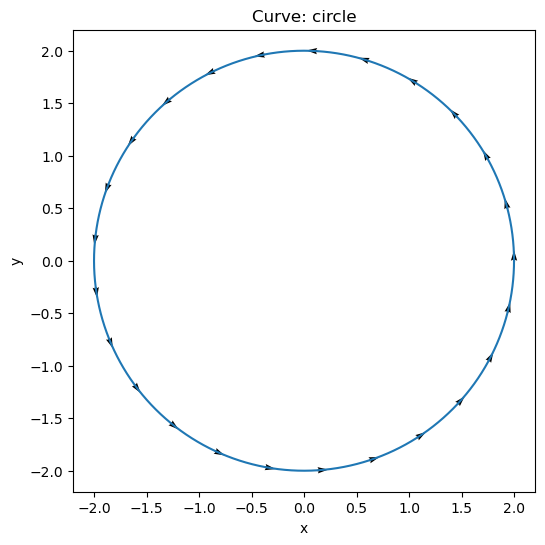

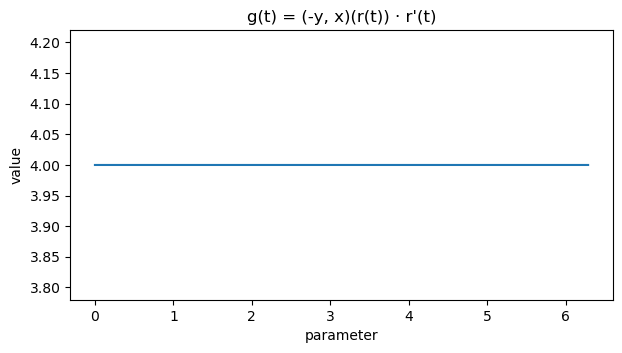

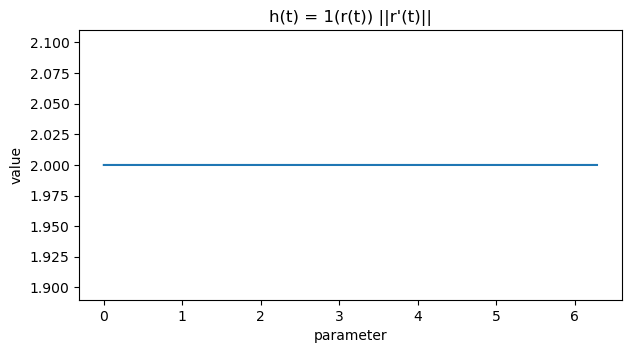

Arc-length parameterized domain: s ∈ [0, L], L ~ 12.566370614359172
∮ F_rot · dr (arc-length param) ~ 25.132741228553705
Green check: {'lhs_circulation': 25.132741228718345, 'rhs_area_curl': 25.129183116660936, 'abs_error': 0.0035581120574086356, 'rel_error': 0.0001415727805028645}


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Optional
from typing import Callable, Tuple, Optional, TypeAlias

Vector2D: TypeAlias = np.ndarray
def is_Vector2D(v: np.ndarray) -> bool:
  if not isinstance(v, np.ndarray) or v.shape != (2,0):
    return False
  else:
    return True


# ----------------------------
# Core geometry + fields
# ----------------------------

@dataclass(frozen=True)
class ParametricCurve2D:
  """
  Parametric curve C: r(t) for t ∈ [t0, t1].

  r(t)    = [x(t), y(t)]
  r'(t)   = dr/dt
  """
  r: Callable[[float], Vector2D]
  drdt: Callable[[float], Vector2D]
  t0: float
  t1: float
  name: str = "C"

  def sample(self, N: int = 2000) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
      t = np.linspace(self.t0, self.t1, N)
      R = np.array([self.r(ti) for ti in t], dtype=float)      # (N,2)
      dR = np.array([self.drdt(ti) for ti in t], dtype=float)  # (N,2)
      return t, R, dR

  def is_closed(self, tol: float = 1e-9) -> bool:
      return np.linalg.norm(self.r(self.t0) - self.r(self.t1)) < tol

  def arclength(self, N: int = 20000) -> float:
      t, _, dR = self.sample(N)
      speed = np.linalg.norm(dR, axis=1)
      return float(np.trapezoid(speed, t))

  def reparameterize_by_arclength(self, N_build: int = 20000) -> "ParametricCurve2D":
      """
      Returns a *new* curve with parameter s ∈ [0, L] approximately equal to arc length.
      Implementation:
        - sample original curve at dense t
        - build s(t) = ∫||r'(t)|| dt
        - invert approximately by interpolation t(s)
        - define r_s(s) = r(t(s))
        - define dr/ds via finite differences (numerical)
      """
      t, R, dR = self.sample(N_build)
      speed = np.linalg.norm(dR, axis=1)

      # cumulative arc length s(t)
      dt = t[1] - t[0]
      s = np.cumsum(speed) * dt
      s = s - s[0]
      L = float(s[-1])

      # interpolate t(s) and R(s) using 1D interpolation on each component
      def t_of_s(si: float) -> float:
          return float(np.interp(si, s, t))

      def r_s(si: float) -> Vector2D:
          ti = t_of_s(si)
          return self.r(ti)

      # dr/ds: finite difference on r_s
      eps = 1e-6 * max(L, 1.0)

      def drds(si: float) -> Vector2D:
          s1 = max(0.0, min(L, si - eps))
          s2 = max(0.0, min(L, si + eps))
          if s2 == s1:
              return np.array([0.0, 0.0], dtype=float)
          return (r_s(s2) - r_s(s1)) / (s2 - s1)

      return ParametricCurve2D(r=r_s, drdt=drds, t0=0.0, t1=L, name=f"{self.name}_arclength")


@dataclass(frozen=True)
class VectorField2D:
    """
    Vector field F(x,y) = [Fx, Fy]
    """
    F: Callable[[float, float], Vec2]
    name: str = "F"

    def eval_on(self, R: np.ndarray) -> np.ndarray:
        return np.array([self.F(x, y) for x, y in R], dtype=float)


# ----------------------------
# Line integral engine
# ----------------------------

@dataclass(frozen=True)
class LineIntegral:
    """
    Computes:
      - vector line integral: ∫_C F · dr
      - scalar line integral: ∫_C f ds
      - circulation: ∮_C F · dr (requires closed curve by default)

    Numerical method: trapezoidal rule in parameter space.
    """
    curve: ParametricCurve2D
    N: int = 20000

    # ---- (1) vector line integral ----
    def vector_integrand(self, field: VectorField2D) -> Tuple[np.ndarray, np.ndarray]:
        """
        g(t) = F(r(t)) · r'(t)
        """
        t, R, dR = self.curve.sample(self.N)
        Fvals = field.eval_on(R)
        g = np.einsum("ij,ij->i", Fvals, dR)
        return t, g

    def vector_value(self, field: VectorField2D) -> float:
        t, g = self.vector_integrand(field)
        return float(np.trapezoid(g, t))

    def circulation(self, field: VectorField2D, require_closed: bool = True, tol: float = 1e-9) -> float:
        if require_closed and (not self.curve.is_closed(tol=tol)):
            raise ValueError(f"Curve '{self.curve.name}' not closed (endpoint mismatch > {tol}).")
        return self.vector_value(field)

    # ---- (2) scalar line integral ----
    def scalar_integrand(self, f: Callable[[float, float], float]) -> Tuple[np.ndarray, np.ndarray]:
        """
        h(t) = f(r(t)) * ||r'(t)||
        so ∫_C f ds = ∫ h(t) dt
        """
        t, R, dR = self.curve.sample(self.N)
        speed = np.linalg.norm(dR, axis=1)
        vals = np.array([f(x, y) for x, y in R], dtype=float)
        h = vals * speed
        return t, h

    def scalar_value(self, f: Callable[[float, float], float]) -> float:
        t, h = self.scalar_integrand(f)
        return float(np.trapezoid(h, t))

    # ---- (3) visualization ----
    def plot_curve(self, ax=None, N_plot: int = 2000, show_tangent: bool = False, every: int = 80):
        t, R, dR = self.curve.sample(N_plot)
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot(R[:, 0], R[:, 1])
        ax.set_aspect("equal", "box")
        ax.set_title(f"Curve: {self.curve.name}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        if show_tangent:
            idx = np.arange(0, len(t), every)
            # normalize tangents for drawing
            T = dR[idx]
            norms = np.linalg.norm(T, axis=1)
            norms[norms == 0] = 1.0
            Tn = (T.T / norms).T
            ax.quiver(R[idx, 0], R[idx, 1], Tn[:, 0], Tn[:, 1], angles="xy", scale_units="xy", scale=10)

        return ax

    def plot_integrand(self, y: np.ndarray, t: np.ndarray, title: str = "Integrand"):
        fig, ax = plt.subplots(figsize=(7, 3.5))
        ax.plot(t, y)
        ax.set_title(title)
        ax.set_xlabel("parameter")
        ax.set_ylabel("value")
        return ax

    def plot_vector_integrand(self, field: VectorField2D):
        t, g = self.vector_integrand(field)
        return self.plot_integrand(g, t, title=f"g(t) = {field.name}(r(t)) · r'(t)")

    def plot_scalar_integrand(self, f: Callable[[float, float], float], fname: str = "f"):
        t, h = self.scalar_integrand(f)
        return self.plot_integrand(h, t, title=f"h(t) = {fname}(r(t)) ||r'(t)||")

    # ---- (4) Green's theorem check (circulation vs area integral of curl) ----
    @staticmethod
    def _partial_derivative(func: Callable[[float, float], float], x: float, y: float, var: str, eps: float) -> float:
        if var == "x":
            return (func(x + eps, y) - func(x - eps, y)) / (2 * eps)
        if var == "y":
            return (func(x, y + eps) - func(x, y - eps)) / (2 * eps)
        raise ValueError("var must be 'x' or 'y'")

    def greens_theorem_check(
        self,
        field: VectorField2D,
        domain: str = "disk",
        domain_params: Optional[dict] = None,
        grid_N: int = 600,
        eps_deriv: float = 1e-5,
        tol_closed: float = 1e-9,
    ) -> dict:
        """
        Compare:
          LHS = ∮_C F · dr
          RHS = ∬_D (∂F_y/∂x - ∂F_x/∂y) dA

        domain options:
          - "disk": uses radius R from domain_params["R"]
          - "bbox": bounding box from curve samples; integrates over its interior with mask from winding test (approx)

        Practical (teaching) version:
          - disk is easiest and stable
          - bbox is more general but uses a coarse inside-mask method

        Returns dict with lhs, rhs, abs_error, rel_error.
        """
        if not self.curve.is_closed(tol=tol_closed):
            raise ValueError("Green's theorem check requires a closed curve.")

        lhs = self.circulation(field, require_closed=True, tol=tol_closed)

        # Define curl_z(x,y) = dFy/dx - dFx/dy
        def Fx(x, y): return float(field.F(x, y)[0])
        def Fy(x, y): return float(field.F(x, y)[1])

        def curl_z(x, y):
            dFydx = self._partial_derivative(Fy, x, y, "x", eps_deriv)
            dFxdy = self._partial_derivative(Fx, x, y, "y", eps_deriv)
            return dFydx - dFxdy

        if domain_params is None:
            domain_params = {}

        if domain == "disk":
            R = float(domain_params.get("R", 1.0))
            # integrate curl over disk using grid mask
            xs = np.linspace(-R, R, grid_N)
            ys = np.linspace(-R, R, grid_N)
            dx = xs[1] - xs[0]
            dy = ys[1] - ys[0]
            X, Y = np.meshgrid(xs, ys, indexing="xy")
            mask = (X**2 + Y**2) <= R**2
            # vectorize curl eval
            curl_vals = np.zeros_like(X, dtype=float)
            idx = np.argwhere(mask)
            for i, j in idx:
                curl_vals[i, j] = curl_z(X[i, j], Y[i, j])
            rhs = float(np.sum(curl_vals[mask]) * dx * dy)

        elif domain == "bbox":
            # approximate interior using winding / ray casting on sampled polygon
            t, Rpts, _ = self.curve.sample(min(self.N, 8000))
            poly = Rpts  # (M,2)
            xmin, ymin = poly.min(axis=0)
            xmax, ymax = poly.max(axis=0)

            xs = np.linspace(xmin, xmax, grid_N)
            ys = np.linspace(ymin, ymax, grid_N)
            dx = xs[1] - xs[0]
            dy = ys[1] - ys[0]
            X, Y = np.meshgrid(xs, ys, indexing="xy")

            # ray casting point-in-polygon
            def inside_polygon(x, y, P):
                inside = False
                x0, y0 = P[-1]
                for x1, y1 in P:
                    cond = ((y1 > y) != (y0 > y)) and (x < (x0 - x1) * (y - y1) / (y0 - y1 + 1e-30) + x1)
                    if cond:
                        inside = not inside
                    x0, y0 = x1, y1
                return inside

            mask = np.zeros_like(X, dtype=bool)
            for i in range(grid_N):
                for j in range(grid_N):
                    mask[i, j] = inside_polygon(X[i, j], Y[i, j], poly)

            curl_vals = np.zeros_like(X, dtype=float)
            idx = np.argwhere(mask)
            for i, j in idx:
                curl_vals[i, j] = curl_z(X[i, j], Y[i, j])
            rhs = float(np.sum(curl_vals[mask]) * dx * dy)

        else:
            raise ValueError("domain must be 'disk' or 'bbox'.")

        abs_err = abs(lhs - rhs)
        rel_err = abs_err / (abs(lhs) + 1e-15)

        return {"lhs_circulation": lhs, "rhs_area_curl": rhs, "abs_error": abs_err, "rel_error": rel_err}


# ----------------------------
# Demonstrations
# ----------------------------

# (A) Circle curve
R0 = 2.0
circle = ParametricCurve2D(
    r=lambda t: np.array([R0*np.cos(t), R0*np.sin(t)]),
    drdt=lambda t: np.array([-R0*np.sin(t), R0*np.cos(t)]),
    t0=0.0,
    t1=2*np.pi,
    name="circle"
)

# Fields:
F_cons = VectorField2D(F=lambda x, y: np.array([2*x, 2*y]), name="∇(x^2+y^2)")
F_rot  = VectorField2D(F=lambda x, y: np.array([-y, x]), name="(-y, x)")

LI = LineIntegral(curve=circle, N=40000)

# (1) vector line integral / circulation
I_cons = LI.circulation(F_cons)
I_rot  = LI.circulation(F_rot)
print("∮ F_cons · dr ~", I_cons)
print("∮ F_rot  · dr ~", I_rot, "  (expected =", 2*np.pi*R0**2, ")")

# (2) scalar line integral: ∫_C f ds
# Example: f(x,y) = 1 => arc length of the curve
f1 = lambda x, y: 1.0
L_num = LI.scalar_value(f1)
print("∫_C 1 ds ~", L_num, "  (expected circumference =", 2*np.pi*R0, ")")

# (3) plot curve and integrands
LI.plot_curve(show_tangent=True)
plt.show()

LI.plot_vector_integrand(F_rot)
plt.show()

LI.plot_scalar_integrand(f1, fname="1")
plt.show()

# (4) arc-length reparameterization
circle_s = circle.reparameterize_by_arclength(N_build=60000)
LI_s = LineIntegral(curve=circle_s, N=40000)
print("Arc-length parameterized domain: s ∈ [0, L], L ~", circle_s.t1)

# Compare the same circulation computed in the s-parameterization
I_rot_s = LI_s.circulation(F_rot)
print("∮ F_rot · dr (arc-length param) ~", I_rot_s)

# (5) Green's theorem check on disk domain
# For this circle, the interior is exactly a disk of radius R0.
greens = LI.greens_theorem_check(F_rot, domain="disk", domain_params={"R": R0}, grid_N=700, eps_deriv=2e-5)
print("Green check:", greens)


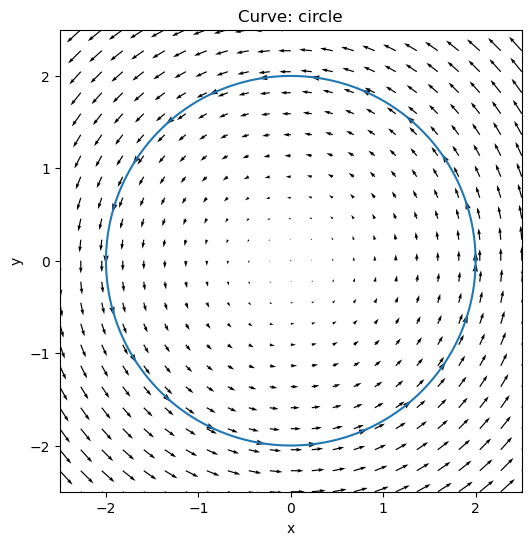

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vector_field(field, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5), n=25, ax=None, title=None):
    xs = np.linspace(xlim[0], xlim[1], n)
    ys = np.linspace(ylim[0], ylim[1], n)
    X, Y = np.meshgrid(xs, ys, indexing="xy")

    U = np.zeros_like(X, dtype=float)
    V = np.zeros_like(Y, dtype=float)

    for i in range(n):
        for j in range(n):
            Fx, Fy = field.F(X[i, j], Y[i, j])
            U[i, j] = Fx
            V[i, j] = Fy

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.quiver(X, Y, U, V, angles="xy")
    ax.set_aspect("equal", "box")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title if title else f"Vector field: {field.name}")
    return ax

ax = plot_vector_field(F_rot, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5), n=23)
LI.plot_curve(ax=ax, show_tangent=True, every=90)
plt.show()



In [15]:
def plot_curve_colored_by_tangential_component(LI, field, N_plot=1500):
    t, R, dR = LI.curve.sample(N_plot)
    speed = np.linalg.norm(dR, axis=1)
    speed[speed == 0] = 1.0
    t_hat = (dR.T / speed).T

    Fvals = field.eval_on(R)
    Ft = np.einsum("ij,ij->i", Fvals, t_hat)  # tangential component

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal", "box")
    ax.set_title(f"Curve colored by tangential component: {field.name}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    sc = ax.scatter(R[:, 0], R[:, 1], c=Ft, s=6)
    fig.colorbar(sc, ax=ax, label=r"$F_t = \mathbf{F}\cdot\hat{\mathbf{t}}$")
    return ax


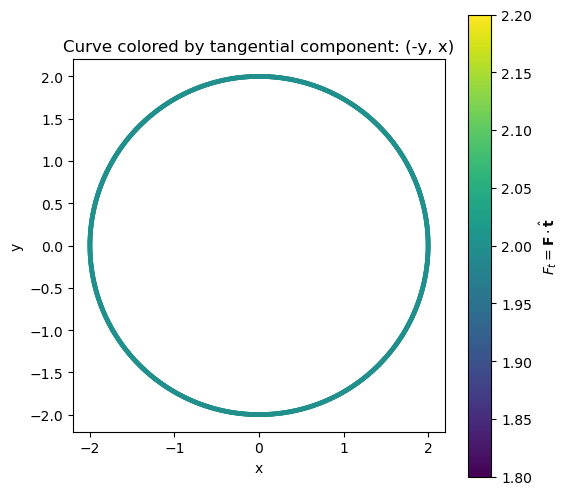

In [16]:
plot_curve_colored_by_tangential_component(LI, F_rot)
plt.show()
